In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import segyio # não sendo usada
import scipy.signal
import scipy.interpolate
import pylops
import seaborn as sns
import scipy.linalg
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [23]:
# importação das superfícies
eoceno = pd.read_csv("Superficies/EocenoSuperior_SubvolBackground_Time.dat",
                     delim_whitespace=True, skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

paleoceno = pd.read_csv("Superficies/Paleoceno_SubvolBackground_Time.dat",
                        delim_whitespace=True, skiprows=0, usecols=(0, 1, 2), names=['X', 'Y', 'Z'])

# determinação dos limites
xl_start = np.min(eoceno['Y'])
xl_end = np.max(eoceno['Y'])

amp = np.load("Sismica/sismica_497.npy")
mback = np.load("Impedancia/lowfrequency_497.npy") #
wav = np.load("Wavelets/wav_avg.npy")
print(f" amp shape {np.shape(amp)}")
print(f" amp shape {np.shape(mback)}")
print(f" amp shape {np.shape(wav)}")

 amp shape (1051, 1751)
 amp shape (1051, 1751)
 amp shape (30,)


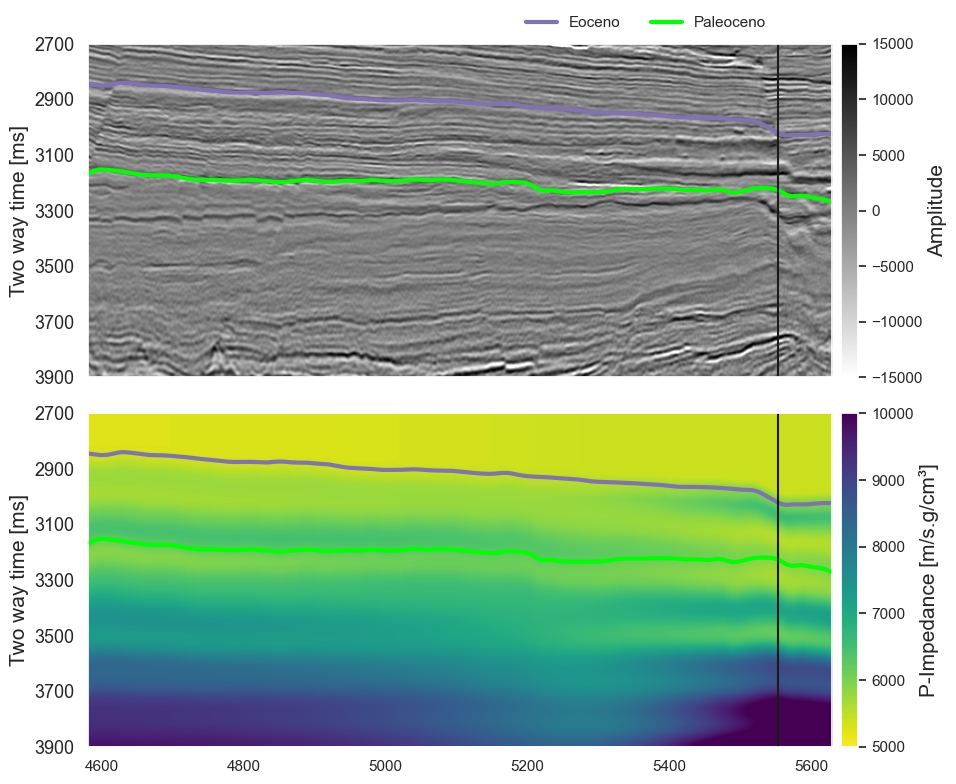

In [3]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c=axs[0].imshow(amp.T, # Amplitude
                aspect='auto',
                cmap='gray_r',
                vmin=-15000,
                vmax=15000,
                extent=[xl_start, xl_end, 7000, 0])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

c=axs[1].imshow(mback.T, # Impedância de baixa freq.
                aspect='auto',
                cmap='viridis_r',
                vmin=5000,
                vmax=10000,
                extent=[xl_start, xl_end, 7000, 0])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)


for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3900, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3901, 200))
    ax.set_yticklabels(np.arange(2700, 3901, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()
#plt.savefig('Figures/lowfrequency_497.png', dpi=200, bbox_inches='tight')

In [187]:
# Convertendo de tempo para profundidade

path = "Pocos/IP_UPS/"

df = pd.DataFrame()
names = ['Depth', 'VP', 'RHO', 'VP_4Hz', 'RHO_4Hz', 'VP_6Hz', 'RHO_6Hz',
         'VP_8Hz', 'RHO_8Hz', 'IP', 'IP_4Hz', 'IP_6Hz', 'IP_8Hz']

for file in os.listdir(path):
    well = pd.read_csv(path+file,
                       delim_whitespace=True,
                       skiprows=1,
                       names=names)

    # Replacing nans. The value 1e30 is a null value.
    well.replace(1e30, np.nan, inplace=True)

    # Naming well
    well['WELL'] = file.split('_')[0]
    time_vs_depth = pd.read_csv(f'Pocos/TimeVsDepth/{file.split("_")[0]}.dat', skiprows=14, sep='\s+',
                      names=['MD', 'TVD', 'TVDSS', 'TWT', 'VINT'])
    interp_time_vs_depth = scipy.interpolate.interp1d(time_vs_depth['MD'], time_vs_depth['TWT'],
                                                      fill_value='extrapolate', bounds_error=False)
    t_well = interp_time_vs_depth(well.Depth)

    new_samples = np.arange(2700, 3900, 4)
    interp2 = scipy.interpolate.interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')
    ip_ups = interp2(new_samples) # impedance upsampled
    ip_ups = scipy.ndimage.gaussian_filter(ip_ups, sigma=0.5)

    arr = np.array([new_samples, ip_ups])
    nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS'])
    nwell['WELL'] = file.split('_')[0]
    nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')
    for i in nwell.WELL.unique():
        plt.title(i)
        plt.plot(nwell[nwell['WELL'] == i]['IP_UPS'])
        plt.savefig(f'Figures/{i}.png', dpi=200, bbox_inches='tight')
        plt.clf()
    df = pd.concat([df, nwell], ignore_index=True)


<Figure size 640x480 with 0 Axes>

(2400, 2400)
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(2400, 2400)


Text(0, 0.5, 'Amplitude')

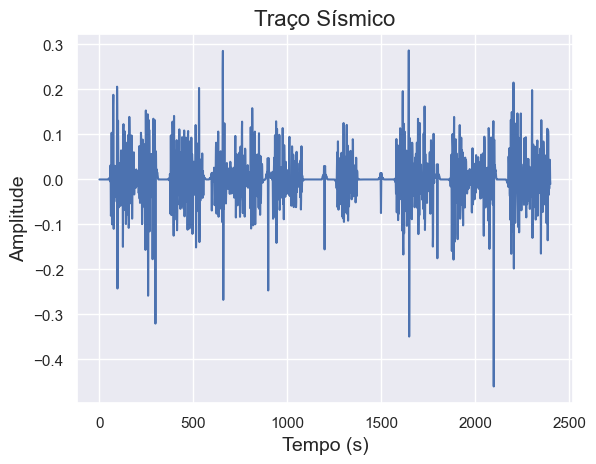

In [6]:
nd = len(df['IP_UPS'])
ns = len(wav)

S = scipy.linalg.toeplitz(np.append(wav, np.zeros(2*nd-ns)),np.zeros(nd))[(ns)//2:nd+((ns)//2)]
print(np.shape(S))

matder = np.zeros(shape=(nd,nd))

for i in range(nd):
  matder[i][i] = -1
  if i<nd-1:
    matder[i][i+1] = 1
  else:
    matder[i][i] = 0
#
print(matder)
print(np.shape(matder))

refl = 0.5 * matder @ np.log(df['IP_UPS'])
traco = S @ refl
plt.plot(traco)
plt.title('Traço Sísmico', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

--------------------------------------------------------------------------------------------------------------------------

# Inversão

In [188]:
amp_ls = amp.copy()
mback_ls = mback.copy()

In [189]:
mback_ls[:, 675:975]

array([[ 5250.758 ,  5250.758 ,  5250.758 , ...,  9710.691 ,  9722.23  ,
         9728.516 ],
       [ 5250.746 ,  5250.746 ,  5250.746 , ...,  9710.469 ,  9722.    ,
         9728.281 ],
       [ 5250.7344,  5250.7344,  5250.7344, ...,  9710.246 ,  9721.77  ,
         9728.047 ],
       ...,
       [ 5408.3633,  5408.3633,  5408.3633, ..., 11660.027 , 11731.871 ,
        11770.652 ],
       [ 5408.5   ,  5408.5   ,  5408.5   , ..., 11653.98  , 11725.695 ,
        11764.406 ],
       [ 5408.6367,  5408.6367,  5408.6367, ..., 11647.965 , 11719.547 ,
        11758.1875]], dtype=float32)

In [191]:
# Inverting at well 55 inline
'''
O código está pegando todas as linhas e as colunas de 675 a 974 da matriz `mback_ls`.
'''

amp_ls = amp[:, 675:975].T
mback_ls = np.log(mback[:, 675:975].T)

print("Shape of data [n_samples, n_traces]:", amp_ls.shape)
print("Shape of data [n_samples, n_traces]:", mback_ls.shape)

Shape of data [n_samples, n_traces]: (300, 1051)
Shape of data [n_samples, n_traces]: (300, 1051)


In [421]:
# Wavelet operator
nz, nx = amp_ls.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(wav/2,
                                                     nt0=nz,
                                                     spatdims=nx,
                                                     explicit=True)

# Trace-by-trace - y = Op * m
m_inv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop, # operador de modelagem direta (G)
    y = amp_ls.ravel() / 30000, # dado observado.
    Regs=None,
    epsI=5e-1,
    x0 = mback_ls.ravel(), # modelo inicial
    engine='scipy',
    **dict(maxiter=50, show=True))
m_inv_tbt = np.exp(mback_ls + m_inv_tbt.reshape(nz, nx))


NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 315300 rows and 315300 cols
Regs=None
epsRs=None     epsI=0.5
-------------------------------------------------------


In [418]:
np.shape(m_inv_tbt)

(300, 1051)

In [419]:
# Second derivative regularization operator
D2op = pylops.SecondDerivative(nz*nx, dtype='float64')

(4000.0, 10000.0)

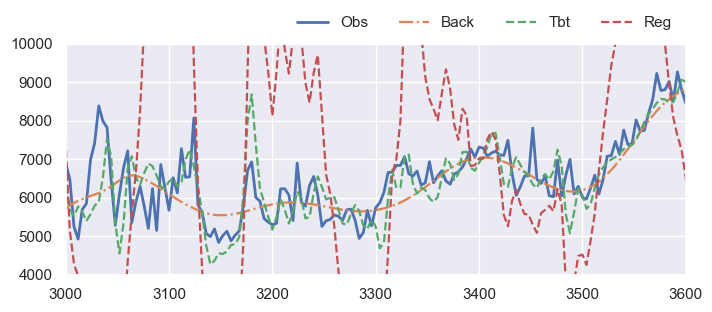

In [424]:
# Regularized function
m_inv_reg, _, _, _, _ = pylops.optimization.leastsquares.regularized_inversion(
    Op=PPop, # operador de modelagem direta (G)
    y = amp_ls.ravel() / 30000, # dado observado.
    Regs=[D2op], # regularization operator
    x0 = mback_ls.ravel(), # modelo inicial
    **dict(damp=np.sqrt(1e-4), iter_lim=100, show=0))

m_inv_reg = np.exp(m_inv_reg.reshape(nz, nx))

plt.figure(figsize=(8, 3))

plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, label='Obs', lw=2.0)
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, np.exp(mback_ls[:, 5553-xl_start]), label='Back', lw=1.6, ls='-.')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, m_inv_tbt[:, 5553-xl_start], label='Tbt', lw=1.6, ls='--')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, m_inv_reg[:, 5553-xl_start], label='Reg', lw=1.6, ls='--')
#plt.plot(new_twt, minv_hop[:, 1469-new_xl_start], label='Hor', lw=1.6, ls='--')
#plt.plot(new_twt, minv_dop[:, 1469-new_xl_start], label='Dir', lw=1.6, ls='--')
#plt.plot(new_twt, bsd[1269 - new_il_start, 1469-new_xl_start, :], label='Petrel', lw=1.6, ls='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), edgecolor='w', facecolor='w', ncol=5)

plt.xlim(3000, 3600)
plt.ylim(4000, 10000)
#plt.savefig('Figures/inversion_497_well.png', dpi=200, bbox_inches='tight')

In [393]:
img = np.tile(df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, (100, 1))

# TRACE BY TRACE

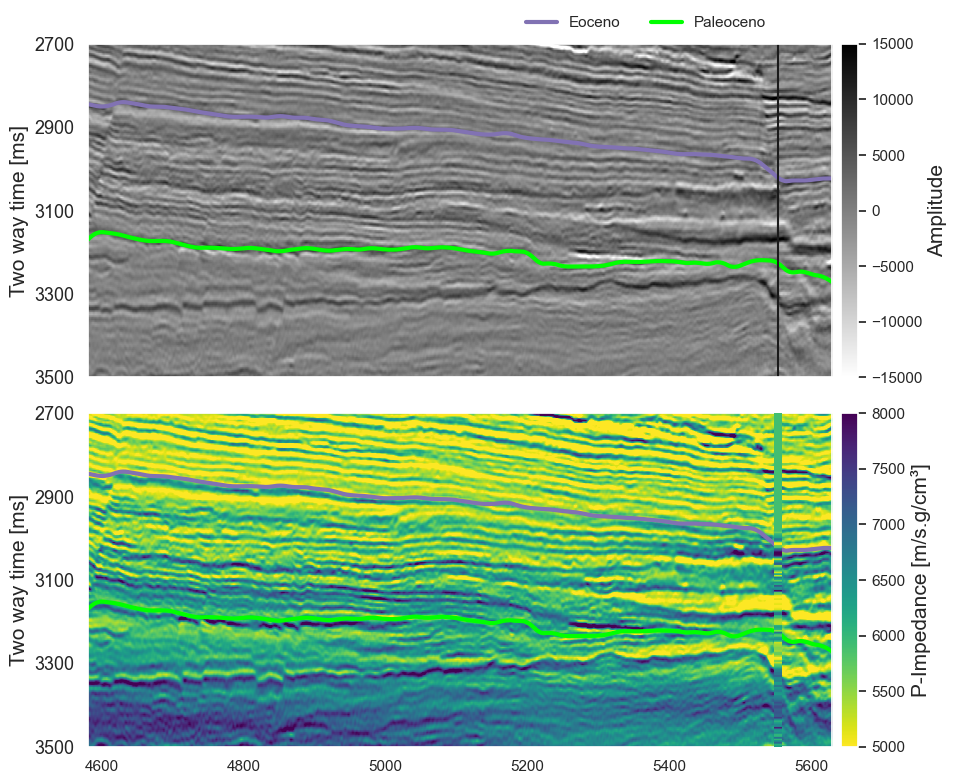

In [394]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# amplitude
c=axs[0].imshow(amp_ls, aspect='auto', cmap='gray_r', vmin=-15000,
                vmax=15000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

# inversion trace-by-trace
c=axs[1].imshow(m_inv_tbt, aspect='auto', cmap='viridis_r', vmin=5000,
                vmax=8000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)

# well impedance
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5553-5, 5553+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

# REGULARIZED

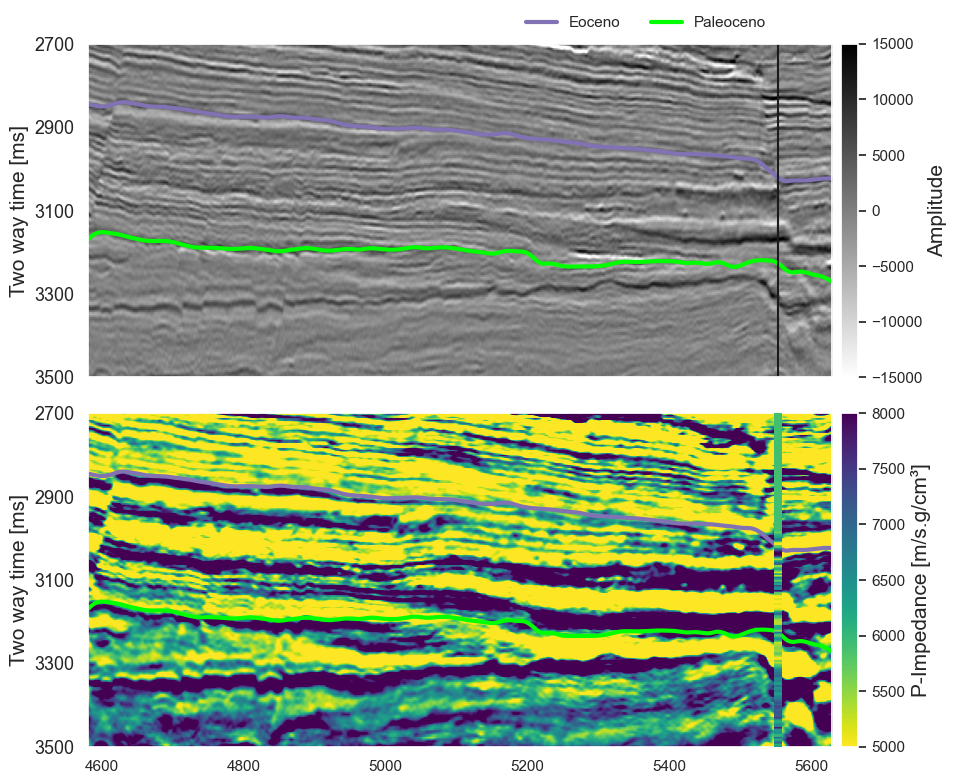

In [425]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# amplitude
c=axs[0].imshow(amp_ls, aspect='auto', cmap='gray_r', vmin=-15000,
                vmax=15000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[0], pad=0.01).set_label('Amplitude', size=15)

# inversion trace-by-trace
c=axs[1].imshow(m_inv_reg, aspect='auto', cmap='viridis_r', vmin=5000,
                vmax=8000, extent=[xl_start, xl_end, 3900, 2700])
plt.colorbar(c, ax=axs[1], pad=0.01).set_label('P-Impedance [m/s.g/cm³]', size=15)

# well impedance
axs[1].imshow(img.T, aspect='auto', cmap='viridis_r', vmin=5000, vmax=8000,
             extent=(5553-5, 5553+5, 3900, 2700), zorder=20)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    #ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(eoceno.loc[eoceno.X == 2862].Y, eoceno.loc[eoceno.X == 2862].Z,
             color='m', lw=3.0, label='Eoceno')
    ax.plot(paleoceno.loc[paleoceno.X == 2862].Y, paleoceno.loc[paleoceno.X == 2862].Z,
             color='lime', lw=3.0, label='Paleoceno')

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color='k')

axs[0].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.75, 1.0), facecolor='white', edgecolor='white')
axs[0].set_xticks([])
plt.tight_layout()

(4000.0, 10000.0)

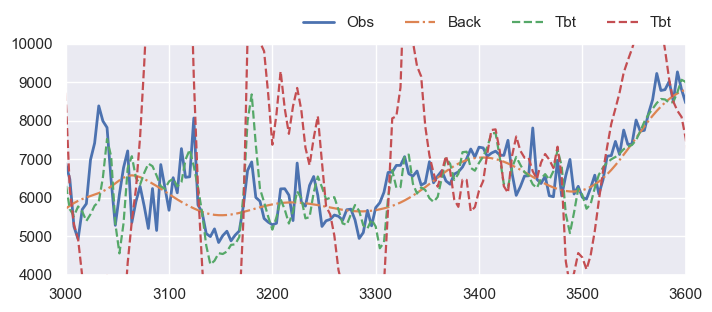

In [396]:
plt.figure(figsize=(8, 3))

plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, df.loc[df.WELL=='6-BRSA-497-ESS'].IP_UPS, label='Obs', lw=2.0)
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, np.exp(mback_ls[:, 5553-xl_start]), label='Back', lw=1.6, ls='-.')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, m_inv_tbt[:, 5553-xl_start], label='Tbt', lw=1.6, ls='--')
plt.plot(df.loc[df.WELL=='6-BRSA-497-ESS'].TWT, m_inv_reg[:, 5553-xl_start], label='Tbt', lw=1.6, ls='--')
#plt.plot(new_twt, minv_hop[:, 1469-new_xl_start], label='Hor', lw=1.6, ls='--')
#plt.plot(new_twt, minv_dop[:, 1469-new_xl_start], label='Dir', lw=1.6, ls='--')
#plt.plot(new_twt, bsd[1269 - new_il_start, 1469-new_xl_start, :], label='Petrel', lw=1.6, ls='--')

plt.legend(loc='lower right', bbox_to_anchor=(1.0, 1.0), edgecolor='w', facecolor='w', ncol=5)

plt.xlim(3000, 3600)
plt.ylim(4000, 10000)
#plt.savefig('Figures/inversion_497_well.png', dpi=200, bbox_inches='tight')

-----------------------------------------------------------------------------------------------------------------------